In [ ]:
from google.colab import drive

drive.mount("/content/gdrive")

Mounted at /content/gdrive


In [ ]:
!unzip '/content/gdrive/MyDrive/2.zip'

Streaming output truncated to the last 5000 lines.
 extracting: 1/train/bird/emu_s_000219.png  
 extracting: 1/train/bird/pipit_s_000192.png  
 extracting: 1/train/bird/flightless_bird_s_000562.png  
 extracting: 1/train/bird/passerine_s_001221.png  
 extracting: 1/train/bird/struthio_camelus_s_000008.png  
  inflating: 1/train/bird/pipit_s_000221.png  
 extracting: 1/train/bird/passerine_s_001226.png  
 extracting: 1/train/bird/emu_s_001158.png  
 extracting: 1/train/bird/accentor_s_000039.png  
 extracting: 1/train/bird/pipit_s_000029.png  
 extracting: 1/train/bird/ostrich_s_002262.png  
 extracting: 1/train/bird/struthio_camelus_s_000156.png  
  inflating: 1/train/bird/flightless_bird_s_000353.png  
 extracting: 1/train/bird/pipit_s_000443.png  
 extracting: 1/train/bird/ostrich_s_000506.png  
  inflating: 1/train/bird/sparrow_s_000490.png  
  inflating: 1/train/bird/ostrich_s_002057.png  
  inflating: 1/train/bird/meadow_pipit_s_000610.png  
 extracting: 1/train/bird/cassowary_s_0

In [ ]:
train_data_dir = "/content/1/train" # put path of training dataset
val_data_dir = "/content/1/val" # put path of test dataset
test_data_dir = "/content/1/test" 

In [ ]:
trainset = torchvision.datasets.ImageFolder(root=train_data_dir, transform=transform)
#divide the data into batches with batch_size=4
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=1)
print(len(trainset))

valnset = torchvision.datasets.ImageFolder(root= val_data_dir, transform=transform)
valloader = torch.utils.data.DataLoader(valnset, batch_size=4,
                                          shuffle=True, num_workers=1)

testset = torchvision.datasets.ImageFolder(root= test_data_dir , transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=4,
                                         shuffle=False, num_workers=1)
print(len(valnset))
print(len(testset))

25000
2500
2500


In [ ]:
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models

# <<<<<<<<<<<<<<<<<<<<< EDIT THE MODEL DEFINITION >>>>>>>>>>>>>>>>>>>>>>>>>>
# Try experimenting by changing the following:
# 1. number of feature maps in conv layer
# 2. Number of conv layers
# 3. Kernel size
# etc etc.,

num_epochs = 50        # desired number of training epochs.
learning_rate = 0.001   

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=3, out_channels=64, kernel_size=3, padding=1)
        # self.conv2 = nn.Conv2d(in_channels=64, out_channels=256, kernel_size=3, padding=1)
        # self.conv3 = nn.Conv2d(in_channels=256, out_channels=256, kernel_size=3, padding=1)
        
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(in_features=64, out_features=256)
        self.fc2 = nn.Linear(in_features=256, out_features=128)
        self.fc3 = nn.Linear(in_features=128, out_features=5)
         # 5 is the number of classes here (for batch 3,4,5 out_features is 33)

    def forward(self, x): 

        x = F.relu(self.conv1(x))
        x = self.pool(x)
        
        # x = F.relu(self.conv2(x))
        # x = self.pool(x)
        
        # x = F.relu(self.conv3(x))
        # x = self.pool(x)
        
        x = F.avg_pool2d(x, kernel_size=x.shape[2:])
        x = x.view(x.shape[0], -1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        
        return x  

################### DO NOT EDIT THE BELOW CODE!!! #######################

net = Net()

# transfer the model to GPU
if torch.cuda.is_available():
    net = net.cuda()
net.load_state_dict(torch.load('./models/bestmodelconv1.pth'))
########################################################################
# Define a Loss function and optimizer
# ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
# Let's use a Classification Cross-Entropy loss and SGD with momentum.

import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=learning_rate, momentum=0.9, weight_decay=5e-4)

num_params = np.sum([p.nelement() for p in net.parameters()])
print(num_params, ' parameters')

########################################################################
# Train the network
# ^^^^^^^^^^^^^^^^^^^^

def train(epoch, trainloader, optimizer, criterion,net):
    running_loss = 0.0
    correct=0
    total=0
    for i, data in enumerate(tqdm(trainloader), 0):
        # get the inputs
        inputs, labels = data
        if torch.cuda.is_available():
            inputs, labels = inputs.cuda(), labels.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    

    print('epoch %d training loss: %.3f' %
            (epoch + 1, running_loss / (len(trainloader))))
    print('Accuracy of the network on the train images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

    
########################################################################
# Let us look at how the network performs on the test dataset.

def test(testloader, model):
    correct = 0
    total = 0
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %f %%' % (
                                    100 * correct / total))
    return (100* correct/total)

#########################################################################
# get details of classes and class to index mapping in a directory
def find_classes(dir):
    classes = [d for d in os.listdir(dir) if os.path.isdir(os.path.join(dir, d))]
    classes.sort()
    class_to_idx = {classes[i]: i for i in range(len(classes))}
    return classes, class_to_idx


def classwise_test(testloader, model):
########################################################################
# class-wise accuracy

    classes, _ = find_classes(train_data_dir)
    n_class = len(classes) # number of classes

    class_correct = list(0. for i in range(n_class))
    class_total = list(0. for i in range(n_class))
    with torch.no_grad():
        for data in tqdm(testloader):
            images, labels = data
            if torch.cuda.is_available():
                images, labels = images.cuda(), labels.cuda()        
            outputs = model(images)
            _, predicted = torch.max(outputs, 1)
            c = (predicted == labels).squeeze()
            for i in range(4):
                label = labels[i]
                class_correct[label] += c[i].item()
                class_total[label] += 1

    for i in range(n_class):
        print('Accuracy of %10s : %2f %%' % (
            classes[i], 100 * class_correct[i] / class_total[i]))

print('Start Training')
os.makedirs('./models', exist_ok=True)
train_accuracies=[]
test_accuracies=[]
val_accuracies=[]

for epoch in range(num_epochs):  # loop over the dataset multiple times
    print('epoch ', epoch + 51)
    train_accuracy=train(epoch, trainloader, optimizer, criterion,net)
    train_accuracies.append(train_accuracy)
    val_accuracy=test(valloader, net)
    val_accuracies.append(val_accuracy)
    # test_accuracy=test(testloader, net)
    # test_accuracies.append(test_accuracy)
#     classwise_test(valloader, net)
    # save model checkpoint 
    torch.save(net.state_dict(), './models/model'+str(epoch)+'.pth')      

print('performing test')
test_accuracy=test(testloader, net)
classwise_test(testloader, net)

print('Finished Training')

# Saving our trained model
torch.save(net.state_dict(), './models/bestmodelconv1.pth')

51973  parameters
Start Training
epoch  51


100%|██████████| 6250/6250 [00:32<00:00, 191.22it/s]


epoch 1 training loss: 0.982
Accuracy of the network on the train images: 57.620000 %


100%|██████████| 625/625 [00:02<00:00, 216.58it/s]


Accuracy of the network on the test images: 57.120000 %
epoch  52


100%|██████████| 6250/6250 [00:32<00:00, 192.87it/s]


epoch 2 training loss: 0.981
Accuracy of the network on the train images: 57.568000 %


100%|██████████| 625/625 [00:02<00:00, 219.44it/s]


Accuracy of the network on the test images: 57.760000 %
epoch  53


100%|██████████| 6250/6250 [00:32<00:00, 194.83it/s]


epoch 3 training loss: 0.983
Accuracy of the network on the train images: 57.780000 %


100%|██████████| 625/625 [00:02<00:00, 216.44it/s]


Accuracy of the network on the test images: 58.320000 %
epoch  54


100%|██████████| 6250/6250 [00:32<00:00, 194.48it/s]


epoch 4 training loss: 0.979
Accuracy of the network on the train images: 57.924000 %


100%|██████████| 625/625 [00:02<00:00, 216.22it/s]


Accuracy of the network on the test images: 57.560000 %
epoch  55


100%|██████████| 6250/6250 [00:32<00:00, 194.29it/s]


epoch 5 training loss: 0.978
Accuracy of the network on the train images: 57.664000 %


100%|██████████| 625/625 [00:02<00:00, 214.96it/s]


Accuracy of the network on the test images: 57.560000 %
epoch  56


100%|██████████| 6250/6250 [00:32<00:00, 195.24it/s]


epoch 6 training loss: 0.977
Accuracy of the network on the train images: 57.900000 %


100%|██████████| 625/625 [00:02<00:00, 213.82it/s]


Accuracy of the network on the test images: 57.680000 %
epoch  57


100%|██████████| 6250/6250 [00:31<00:00, 195.60it/s]


epoch 7 training loss: 0.975
Accuracy of the network on the train images: 57.856000 %


100%|██████████| 625/625 [00:02<00:00, 216.49it/s]


Accuracy of the network on the test images: 57.440000 %
epoch  58


100%|██████████| 6250/6250 [00:32<00:00, 192.42it/s]


epoch 8 training loss: 0.975
Accuracy of the network on the train images: 57.984000 %


100%|██████████| 625/625 [00:02<00:00, 217.79it/s]


Accuracy of the network on the test images: 57.920000 %
epoch  59


100%|██████████| 6250/6250 [00:32<00:00, 192.65it/s]


epoch 9 training loss: 0.974
Accuracy of the network on the train images: 58.056000 %


100%|██████████| 625/625 [00:02<00:00, 211.27it/s]


Accuracy of the network on the test images: 57.640000 %
epoch  60


100%|██████████| 6250/6250 [00:34<00:00, 183.21it/s]


epoch 10 training loss: 0.973
Accuracy of the network on the train images: 58.284000 %


100%|██████████| 625/625 [00:02<00:00, 217.05it/s]


Accuracy of the network on the test images: 58.160000 %
epoch  61


100%|██████████| 6250/6250 [00:33<00:00, 188.45it/s]


epoch 11 training loss: 0.968
Accuracy of the network on the train images: 58.412000 %


100%|██████████| 625/625 [00:02<00:00, 218.34it/s]


Accuracy of the network on the test images: 58.840000 %
epoch  62


100%|██████████| 6250/6250 [00:36<00:00, 171.42it/s]


epoch 12 training loss: 0.967
Accuracy of the network on the train images: 58.544000 %


100%|██████████| 625/625 [00:02<00:00, 217.14it/s]


Accuracy of the network on the test images: 58.120000 %
epoch  63


100%|██████████| 6250/6250 [00:32<00:00, 190.86it/s]


epoch 13 training loss: 0.968
Accuracy of the network on the train images: 58.616000 %


100%|██████████| 625/625 [00:02<00:00, 211.31it/s]


Accuracy of the network on the test images: 58.720000 %
epoch  64


100%|██████████| 6250/6250 [00:32<00:00, 192.15it/s]


epoch 14 training loss: 0.968
Accuracy of the network on the train images: 58.652000 %


100%|██████████| 625/625 [00:02<00:00, 212.25it/s]


Accuracy of the network on the test images: 56.840000 %
epoch  65


100%|██████████| 6250/6250 [00:32<00:00, 193.03it/s]


epoch 15 training loss: 0.964
Accuracy of the network on the train images: 58.632000 %


100%|██████████| 625/625 [00:02<00:00, 217.18it/s]


Accuracy of the network on the test images: 58.240000 %
epoch  66


100%|██████████| 6250/6250 [00:32<00:00, 192.69it/s]


epoch 16 training loss: 0.963
Accuracy of the network on the train images: 58.540000 %


100%|██████████| 625/625 [00:02<00:00, 215.37it/s]


Accuracy of the network on the test images: 59.920000 %
epoch  67


100%|██████████| 6250/6250 [00:32<00:00, 193.53it/s]


epoch 17 training loss: 0.966
Accuracy of the network on the train images: 58.920000 %


100%|██████████| 625/625 [00:02<00:00, 214.39it/s]


Accuracy of the network on the test images: 57.520000 %
epoch  68


100%|██████████| 6250/6250 [00:32<00:00, 193.06it/s]


epoch 18 training loss: 0.961
Accuracy of the network on the train images: 58.696000 %


100%|██████████| 625/625 [00:02<00:00, 218.70it/s]


Accuracy of the network on the test images: 57.560000 %
epoch  69


100%|██████████| 6250/6250 [00:32<00:00, 192.30it/s]


epoch 19 training loss: 0.961
Accuracy of the network on the train images: 58.428000 %


100%|██████████| 625/625 [00:02<00:00, 215.60it/s]


Accuracy of the network on the test images: 57.360000 %
epoch  70


100%|██████████| 6250/6250 [00:32<00:00, 194.62it/s]


epoch 20 training loss: 0.961
Accuracy of the network on the train images: 58.684000 %


100%|██████████| 625/625 [00:02<00:00, 220.11it/s]


Accuracy of the network on the test images: 57.320000 %
epoch  71


100%|██████████| 6250/6250 [00:32<00:00, 195.13it/s]


epoch 21 training loss: 0.959
Accuracy of the network on the train images: 58.688000 %


100%|██████████| 625/625 [00:02<00:00, 217.40it/s]


Accuracy of the network on the test images: 58.960000 %
epoch  72


100%|██████████| 6250/6250 [00:32<00:00, 194.84it/s]


epoch 22 training loss: 0.957
Accuracy of the network on the train images: 59.136000 %


100%|██████████| 625/625 [00:02<00:00, 216.70it/s]


Accuracy of the network on the test images: 57.800000 %
epoch  73


100%|██████████| 6250/6250 [00:31<00:00, 195.44it/s]


epoch 23 training loss: 0.958
Accuracy of the network on the train images: 59.016000 %


100%|██████████| 625/625 [00:02<00:00, 219.93it/s]


Accuracy of the network on the test images: 59.760000 %
epoch  74


100%|██████████| 6250/6250 [00:31<00:00, 196.19it/s]


epoch 24 training loss: 0.954
Accuracy of the network on the train images: 59.024000 %


100%|██████████| 625/625 [00:02<00:00, 221.79it/s]


Accuracy of the network on the test images: 56.760000 %
epoch  75


100%|██████████| 6250/6250 [00:31<00:00, 196.14it/s]


epoch 25 training loss: 0.954
Accuracy of the network on the train images: 59.048000 %


100%|██████████| 625/625 [00:02<00:00, 219.24it/s]


Accuracy of the network on the test images: 60.120000 %
epoch  76


100%|██████████| 6250/6250 [00:32<00:00, 194.22it/s]


epoch 26 training loss: 0.953
Accuracy of the network on the train images: 59.236000 %


100%|██████████| 625/625 [00:02<00:00, 217.74it/s]


Accuracy of the network on the test images: 58.240000 %
epoch  77


100%|██████████| 6250/6250 [00:31<00:00, 196.52it/s]


epoch 27 training loss: 0.952
Accuracy of the network on the train images: 59.128000 %


100%|██████████| 625/625 [00:02<00:00, 220.66it/s]


Accuracy of the network on the test images: 59.880000 %
epoch  78


100%|██████████| 6250/6250 [00:31<00:00, 195.32it/s]


epoch 28 training loss: 0.953
Accuracy of the network on the train images: 58.996000 %


100%|██████████| 625/625 [00:02<00:00, 215.67it/s]


Accuracy of the network on the test images: 59.800000 %
epoch  79


100%|██████████| 6250/6250 [00:31<00:00, 196.28it/s]


epoch 29 training loss: 0.953
Accuracy of the network on the train images: 59.184000 %


100%|██████████| 625/625 [00:02<00:00, 219.30it/s]


Accuracy of the network on the test images: 58.480000 %
epoch  80


100%|██████████| 6250/6250 [00:31<00:00, 196.55it/s]


epoch 30 training loss: 0.949
Accuracy of the network on the train images: 59.432000 %


100%|██████████| 625/625 [00:02<00:00, 222.40it/s]


Accuracy of the network on the test images: 57.120000 %
epoch  81


100%|██████████| 6250/6250 [00:31<00:00, 196.53it/s]


epoch 31 training loss: 0.951
Accuracy of the network on the train images: 59.584000 %


100%|██████████| 625/625 [00:02<00:00, 222.34it/s]


Accuracy of the network on the test images: 58.200000 %
epoch  82


100%|██████████| 6250/6250 [00:31<00:00, 195.73it/s]


epoch 32 training loss: 0.947
Accuracy of the network on the train images: 59.496000 %


100%|██████████| 625/625 [00:02<00:00, 219.90it/s]


Accuracy of the network on the test images: 57.760000 %
epoch  83


100%|██████████| 6250/6250 [00:31<00:00, 196.11it/s]


epoch 33 training loss: 0.947
Accuracy of the network on the train images: 59.604000 %


100%|██████████| 625/625 [00:02<00:00, 219.80it/s]


Accuracy of the network on the test images: 56.640000 %
epoch  84


100%|██████████| 6250/6250 [00:31<00:00, 195.42it/s]


epoch 34 training loss: 0.948
Accuracy of the network on the train images: 59.312000 %


100%|██████████| 625/625 [00:02<00:00, 220.64it/s]


Accuracy of the network on the test images: 59.680000 %
epoch  85


100%|██████████| 6250/6250 [00:31<00:00, 195.53it/s]


epoch 35 training loss: 0.949
Accuracy of the network on the train images: 59.376000 %


100%|██████████| 625/625 [00:02<00:00, 220.47it/s]


Accuracy of the network on the test images: 60.520000 %
epoch  86


100%|██████████| 6250/6250 [00:31<00:00, 196.47it/s]


epoch 36 training loss: 0.945
Accuracy of the network on the train images: 59.292000 %


100%|██████████| 625/625 [00:02<00:00, 219.84it/s]


Accuracy of the network on the test images: 58.840000 %
epoch  87


100%|██████████| 6250/6250 [00:31<00:00, 197.48it/s]


epoch 37 training loss: 0.943
Accuracy of the network on the train images: 59.828000 %


100%|██████████| 625/625 [00:02<00:00, 222.15it/s]


Accuracy of the network on the test images: 58.960000 %
epoch  88


100%|██████████| 6250/6250 [00:31<00:00, 197.74it/s]


epoch 38 training loss: 0.945
Accuracy of the network on the train images: 59.508000 %


100%|██████████| 625/625 [00:02<00:00, 224.30it/s]


Accuracy of the network on the test images: 56.000000 %
epoch  89


100%|██████████| 6250/6250 [00:31<00:00, 198.66it/s]


epoch 39 training loss: 0.944
Accuracy of the network on the train images: 59.512000 %


100%|██████████| 625/625 [00:02<00:00, 218.79it/s]


Accuracy of the network on the test images: 59.800000 %
epoch  90


100%|██████████| 6250/6250 [00:31<00:00, 198.27it/s]


epoch 40 training loss: 0.942
Accuracy of the network on the train images: 59.812000 %


100%|██████████| 625/625 [00:02<00:00, 221.32it/s]


Accuracy of the network on the test images: 58.320000 %
epoch  91


100%|██████████| 6250/6250 [00:31<00:00, 199.77it/s]


epoch 41 training loss: 0.942
Accuracy of the network on the train images: 59.584000 %


100%|██████████| 625/625 [00:02<00:00, 223.99it/s]


Accuracy of the network on the test images: 58.240000 %
epoch  92


100%|██████████| 6250/6250 [00:31<00:00, 198.76it/s]


epoch 42 training loss: 0.944
Accuracy of the network on the train images: 59.908000 %


100%|██████████| 625/625 [00:02<00:00, 219.56it/s]


Accuracy of the network on the test images: 57.960000 %
epoch  93


100%|██████████| 6250/6250 [00:31<00:00, 199.91it/s]


epoch 43 training loss: 0.941
Accuracy of the network on the train images: 59.616000 %


100%|██████████| 625/625 [00:02<00:00, 222.05it/s]


Accuracy of the network on the test images: 59.640000 %
epoch  94


100%|██████████| 6250/6250 [00:31<00:00, 200.41it/s]


epoch 44 training loss: 0.940
Accuracy of the network on the train images: 59.916000 %


100%|██████████| 625/625 [00:02<00:00, 223.80it/s]


Accuracy of the network on the test images: 58.120000 %
epoch  95


100%|██████████| 6250/6250 [00:31<00:00, 199.07it/s]


epoch 45 training loss: 0.940
Accuracy of the network on the train images: 59.984000 %


100%|██████████| 625/625 [00:02<00:00, 224.28it/s]


Accuracy of the network on the test images: 56.680000 %
epoch  96


100%|██████████| 6250/6250 [00:31<00:00, 199.81it/s]


epoch 46 training loss: 0.939
Accuracy of the network on the train images: 59.796000 %


100%|██████████| 625/625 [00:02<00:00, 225.65it/s]


Accuracy of the network on the test images: 60.400000 %
epoch  97


100%|██████████| 6250/6250 [00:31<00:00, 199.04it/s]


epoch 47 training loss: 0.939
Accuracy of the network on the train images: 60.196000 %


100%|██████████| 625/625 [00:02<00:00, 224.18it/s]


Accuracy of the network on the test images: 59.040000 %
epoch  98


100%|██████████| 6250/6250 [00:31<00:00, 200.21it/s]


epoch 48 training loss: 0.938
Accuracy of the network on the train images: 60.116000 %


100%|██████████| 625/625 [00:02<00:00, 221.79it/s]


Accuracy of the network on the test images: 58.040000 %
epoch  99


100%|██████████| 6250/6250 [00:31<00:00, 198.65it/s]


epoch 49 training loss: 0.936
Accuracy of the network on the train images: 60.264000 %


100%|██████████| 625/625 [00:02<00:00, 222.33it/s]


Accuracy of the network on the test images: 59.120000 %
epoch  100


100%|██████████| 6250/6250 [00:31<00:00, 197.05it/s]


epoch 50 training loss: 0.934
Accuracy of the network on the train images: 60.076000 %


100%|██████████| 625/625 [00:02<00:00, 221.01it/s]


Accuracy of the network on the test images: 58.560000 %
performing test


100%|██████████| 625/625 [00:02<00:00, 217.79it/s]


Accuracy of the network on the test images: 59.280000 %


100%|██████████| 625/625 [00:02<00:00, 213.91it/s]

Accuracy of  aeroplane : 66.600000 %
Accuracy of       bird : 59.600000 %
Accuracy of        cat : 58.800000 %
Accuracy of        dog : 28.800000 %
Accuracy of       ship : 82.600000 %
Finished Training


In [ ]:
print(len(train_accuracies))
print(len(val_accuracies))
with open(r'trainconv1.txt', 'a') as fp:
  for item in train_accuracies:
     fp.write("%s\n" % item)


50
50


In [ ]:
with open(r'valconv1.txt', 'a') as fp:
  for item in val_accuracies:
     fp.write("%s\n" % item)

In [ ]:
train_accuracies=[]
with open(r'trainconv1.txt') as f:

    lines = f.read().split()
    print(lines)
    
print(len(lines))

train_accuracies=[float(i) for i in lines]
print(train_accuracies)

['33.912', '42.292', '43.896', '46.94', '47.884', '48.704', '50.024', '50.66', '50.656', '50.94', '51.356', '51.592', '51.94', '52.032', '52.368', '52.496', '52.72', '52.768', '52.984', '52.964', '53.54', '53.456', '54.04', '53.844', '53.82', '53.868', '54.4', '54.704', '54.472', '54.628', '54.792', '55.256', '55.592', '55.692', '55.16', '55.468', '55.44', '55.656', '55.984', '56.268', '56.556', '56.512', '56.212', '56.984', '56.896', '56.912', '56.812', '56.916', '57.376', '57.436', '57.62', '57.568', '57.78', '57.924', '57.664', '57.9', '57.856', '57.984', '58.056', '58.284', '58.412', '58.544', '58.616', '58.652', '58.632', '58.54', '58.92', '58.696', '58.428', '58.684', '58.688', '59.136', '59.016', '59.024', '59.048', '59.236', '59.128', '58.996', '59.184', '59.432', '59.584', '59.496', '59.604', '59.312', '59.376', '59.292', '59.828', '59.508', '59.512', '59.812', '59.584', '59.908', '59.616', '59.916', '59.984', '59.796', '60.196', '60.116', '60.264', '60.076']
100
[33.912, 42.2

In [ ]:
val_accuracies=[]
with open(r'valconv1.txt') as f:

    lines = f.read().split()
    print(lines)
    
print(len(lines))

val_accuracies=[float(i) for i in lines[:100]]
print(val_accuracies)

['42.44', '42.8', '46.44', '48.24', '50.84', '49.44', '49.12', '52.12', '49.16', '50.84', '50.08', '52.16', '52.0', '53.16', '53.2', '53.2', '52.28', '51.96', '52.88', '52.48', '53.56', '52.72', '53.52', '55.6', '54.6', '54.76', '52.28', '51.76', '53.64', '52.04', '54.88', '54.32', '54.36', '53.4', '56.12', '55.64', '53.32', '54.88', '56.24', '53.52', '55.96', '57.88', '56.76', '55.48', '55.8', '55.32', '55.84', '55.92', '56.96', '55.12', '57.12', '57.76', '58.32', '57.56', '57.56', '57.68', '57.44', '57.92', '57.64', '58.16', '58.84', '58.12', '58.72', '56.84', '58.24', '59.92', '57.52', '57.56', '57.36', '57.32', '58.96', '57.8', '59.76', '56.76', '60.12', '58.24', '59.88', '59.8', '58.48', '57.12', '58.2', '57.76', '56.64', '59.68', '60.52', '58.84', '58.96', '56.0', '59.8', '58.32', '58.24', '57.96', '59.64', '58.12', '56.68', '60.4', '59.04', '58.04', '59.12', '58.56', '57.12', '57.76', '58.32', '57.56', '57.56', '57.68', '57.44', '57.92', '57.64', '58.16', '58.84', '58.12', '58.7

In [ ]:
with open(r'finaltrainconv1.txt', 'w') as fp:
  for item in train_accuracies:
     fp.write("%s\n" % item)
with open(r'finalvalconv1.txt', 'w') as fp:
  for item in val_accuracies:
     fp.write("%s\n" % item)


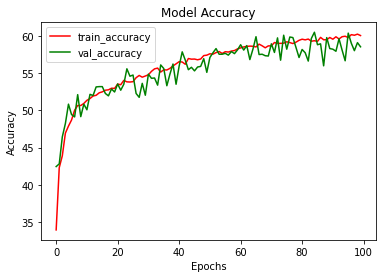

In [ ]:
epochs= np.arange(0, 100, 1)
  
# Assign variables to the y axis part of the curve
y = train_accuracies
z = val_accuracies
  
# Plotting both the curves simultaneously
plt.plot(epochs, y, color='r', label='train_accuracy')
plt.plot(epochs, z, color='g', label='val_accuracy')
  
# Naming the x-axis, y-axis and the whole graph
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
  
# Adding legend, which helps us recognize the curve according to it's color
plt.legend()
  
# To load the display window
plt.show()